# **Cauliflower Disease classification with Deep Learning.**


---



## In This is the file data is trained using with ResNet50V2 Model

In [ ]:
f# Loading the  Data from google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


root_path = '/content/drive/MyDrive/cauliflower-disease-dataset/final_dataset/'
root_path_train = root_path + 'train/'
root_path_test = root_path + 'test/'
root_path_validation = root_path + 'validation/'

Mounted at /content/drive


In [ ]:
import os
os.chdir(root_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing all the necessary packages and modules

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

from tensorflow.keras.applications.mobilenet import MobileNet

# Building data generator function which prepare the training and testing(validating) data , Infact implementing the data augmentation with several parameters.

In [ ]:
def data_generator(color_mode='rgb', img_height=192, img_width=192, batch_size=16, shuffle=True):
  train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
  )
  train_generator = train_datagen.flow_from_directory(
    directory = root_path_train,
    shuffle = shuffle,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    color_mode = color_mode,
    class_mode = 'categorical',
  )

  validation_datagen = ImageDataGenerator(
    rescale = 1./255
  )
  validation_generator = validation_datagen.flow_from_directory(
    directory = root_path_validation,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    color_mode = color_mode,
    class_mode = 'categorical',
  )

  test_generator = validation_datagen.flow_from_directory(
    directory = root_path_test,
    target_size = (img_height, img_height),
    batch_size = batch_size,
    color_mode = color_mode,
    class_mode = 'categorical',
  )

  return train_generator, validation_generator, test_generator

### Defining some constant

In [ ]:
BATCH_SIZE = [16]
# BATCH_SIZE = [64, 32, 16, 8, 4]
EPOCHS = 40
COLOR_MODE = ['rgb']
# IMAGE_SIZE = [224, 192, 160, 128]
IMAGE_SIZE = [512]
# OPTIMIZERS = ['SGD', 'Adam', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl', 'RMSprop']
OPTIMIZERS = ['Adam']

## Making the function which returns the model

In [ ]:
def create_model_resnet50v2(image_size=192, color_mode='rgb', optimizer='adam'):
    color_channel = 3 if color_mode == 'rgb' else 1
    resnet = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, input_shape=(image_size, image_size, color_channel),
                                                     pooling='avg', weights='imagenet')
    model = tf.keras.models.Sequential([
        resnet,
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.layers[0].trainable = False
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    return model



# Model training , here the for loops are for multiple training with several hyperparameters and optimizers.

In [ ]:
# history = []
model_parameters = []
count = 0
# model = []

for batch_len in range(len(BATCH_SIZE)):
  for image_len in range(len(IMAGE_SIZE)):
    for color_len in range(len(COLOR_MODE)):
      for optimizers_len in range(len(OPTIMIZERS)):
        train_generator, validation_generator, test_generator = data_generator(color_mode=COLOR_MODE[color_len], img_height=IMAGE_SIZE[image_len], img_width=IMAGE_SIZE[image_len], batch_size=BATCH_SIZE[batch_len])

        model = create_model_resnet50v2(image_size=IMAGE_SIZE[image_len],color_mode=COLOR_MODE[color_len], optimizer=OPTIMIZERS[optimizers_len])

        # print(len(model))

        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

        print(f'------------------{COLOR_MODE[color_len]}, {BATCH_SIZE[batch_len]}, {IMAGE_SIZE[image_len]}--------------')

        history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=50,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)]
        )
        # batch_size=batch_size[batch_len],

        model_test_results = model.evaluate(test_generator)
        print(f'----------------------{model_test_results}--------------------')
        model_parameters.append((COLOR_MODE[color_len], BATCH_SIZE[batch_len], IMAGE_SIZE[image_len], model_test_results))

        count += 1

Found 545 images belonging to 5 classes.
Found 74 images belonging to 5 classes.
Found 110 images belonging to 5 classes.
94668760/94668760 [==============================] - 1s 0us/step
------------------rgb, 16, 512--------------
Epoch 1/50
35/35 [==============================] - 815s 23s/step - loss: 1.4830 - accuracy: 0.4037 - precision: 0.5090 - recall: 0.1560 - val_loss: 1.1083 - val_accuracy: 0.5811 - val_precision: 0.7083 - val_recall: 0.2297
Epoch 2/50
35/35 [==============================] - 712s 20s/step - loss: 1.0502 - accuracy: 0.6092 - precision: 0.7739 - recall: 0.3706 - val_loss: 0.8965 - val_accuracy: 0.7027 - val_precision: 0.8947 - val_recall: 0.4595
Epoch 3/50
35/35 [==============================] - 709s 20s/step - loss: 0.8657 - accuracy: 0.6936 - precision: 0.8503 - recall: 0.5211 - val_loss: 0.7333 - val_accuracy: 0.7973 - val_precision: 0.9556 - val_recall: 0.5811
Epoch 4/50
35/35 [==============================] - 711s 20s/step - loss: 0.7735 - accuracy: 0.7

## Now ploting the results based on the model performance

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

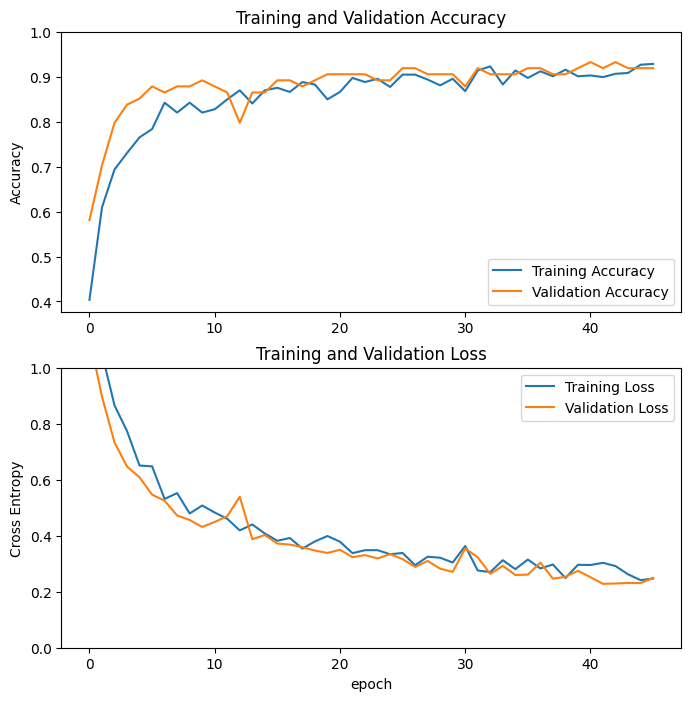

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2,1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
from google.colab import files
plt.savefig("abc.png", dpi=1200)
files.download("abc.png")
# plt.show()


In [ ]:
acc


[0.40366971492767334,
 0.6091743111610413,
 0.6935780048370361,
 0.7302752137184143,
 0.7651376128196716,
 0.7834862470626831,
 0.842201828956604,
 0.820183515548706,
 0.842201828956604,
 0.820183515548706,
 0.8275229334831238,
 0.8495413064956665,
 0.8697247505187988,
 0.8403669595718384,
 0.8697247505187988,
 0.8752293586730957,
 0.8660550713539124,
 0.8880733847618103,
 0.8825688362121582,
 0.8495413064956665,
 0.8660550713539124,
 0.8972477316856384,
 0.8880733847618103,
 0.8954128623008728,
 0.8770642280578613,
 0.9045871496200562,
 0.9045871496200562,
 0.8935779929161072,
 0.8807339668273926,
 0.8954128623008728,
 0.8678898811340332,
 0.9137614965438843,
 0.9229357838630676,
 0.8825688362121582,
 0.9137614965438843,
 0.8972477316856384,
 0.9119266271591187,
 0.9009174108505249,
 0.9155963063240051,
 0.9009174108505249,
 0.9027522802352905,
 0.8990825414657593,
 0.9064220190048218,
 0.9082568883895874,
 0.9266055226325989,
 0.9284403920173645]

In [ ]:
model_path = root_path + 'model/' + 'resnet_aprl30/'
model.save(model_path)

In [ ]:
model_path = root_path + 'model/' + 'resnet_aprl30/'

In [ ]:
saved_model = tf.keras.models.load_model(model_path)

In [ ]:
train_generator, validation_generator, test_generator = data_generator(color_mode='rgb', img_height=512, img_width=512, batch_size=8)

Found 545 images belonging to 5 classes.
Found 74 images belonging to 5 classes.
Found 110 images belonging to 5 classes.


In [ ]:
model_test_results = saved_model.evaluate(test_generator)

14/14 [==============================] - 123s 9s/step - loss: 0.2418 - accuracy: 0.9364 - precision: 0.9515 - recall: 0.8909


## Confusion Matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Y_pred = saved_model.predict_generator(test_generator, 47 // 8+1)
Y_pred = saved_model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cf_matrix = confusion_matrix(test_generator.classes , y_pred)
print(cf_matrix)
print('Classification Report')
target_names = test_generator.class_indices
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

<ipython-input-17-2d83726afac2>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = saved_model.predict_generator(test_generator)


Confusion Matrix
[[4 5 4 4 3]
 [5 2 3 6 4]
 [4 4 4 7 4]
 [1 4 6 4 8]
 [4 6 4 4 6]]
Classification Report
                      precision    recall  f1-score   support

Alternaria Leaf Spot       0.22      0.20      0.21        20
           Black Rot       0.10      0.10      0.10        20
       Cabbage Aphid       0.19      0.17      0.18        23
      Cabbage Looper       0.16      0.17      0.17        23
        Healthy Leaf       0.24      0.25      0.24        24

            accuracy                           0.18       110
           macro avg       0.18      0.18      0.18       110
        weighted avg       0.18      0.18      0.18       110



<Axes: >

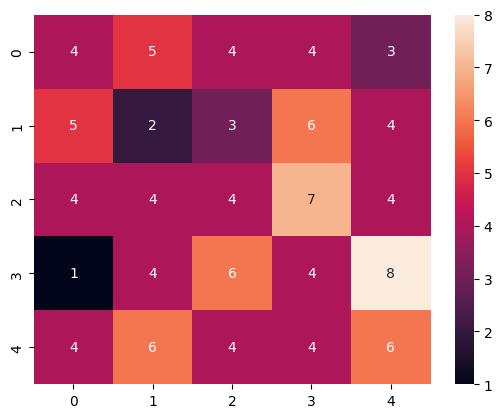

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

## Prediction

In [ ]:
#/content/drive/MyDrive/cauliflower-disease-dataset/final_dataset/test/Alternaria Leaf Spot/20220630614.jpg
# /content/drive/MyDrive/cauliflower-disease-dataset/final_dataset/test/Alternaria Leaf Spot/IMG_20220630_102818.jpg
# /content/drive/MyDrive/cauliflower-disease-dataset/final_dataset/test/Alternaria Leaf Spot/alternaria-bal.jpeg
# /content/drive/MyDrive/cauliflower-disease-dataset/final_dataset/test/Alternaria Leaf Spot/IMG_2022063102809.jpg

In [ ]:
# image = tf.keras.preprocessing.image.load_img(root_path + 'test/Alternaria Leaf Spot/20220630614.jpg', target_size=(512, 512))
# image = tf.keras.preprocessing.image.load_img(root_path + 'test/Alternaria Leaf Spot/IMG_20220630_102818.jpg', target_size=(512, 512))
# image = tf.keras.preprocessing.image.load_img(root_path + 'test/Alternaria Leaf Spot/alternaria-bal.jpeg', target_size=(512, 512))
image = tf.keras.preprocessing.image.load_img(root_path + 'test/Alternaria Leaf Spot/IMG_2022063102809.jpg', target_size=(512, 512))

image = tf.keras.preprocessing.image.img_to_array(image)
image = image/255.0
image = tf.expand_dims(image, 0)
result = saved_model.predict(image)

1/1 [==============================] - 2s 2s/step


In [ ]:
result

array([[9.9582052e-01, 8.2037511e-04, 1.9071675e-03, 1.4517297e-03,
        1.0873636e-07]], dtype=float32)

In [ ]:
labels

{'Alternaria Leaf Spot': 0,
 'Black Rot': 1,
 'Cabbage Aphid': 2,
 'Cabbage Looper': 3,
 'Healthy Leaf': 4}

In [ ]:
labels = train_generator.class_indices
# predicted_class = labels[result.argmax(axis=-1)[0]]
predicted_class = list(labels.keys())[np.argmax(result)]
predicted_class

'Alternaria Leaf Spot'